<a href="https://colab.research.google.com/github/ErickMM98/stimate_covid_pdparams/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Coronavirus

This project consist to estimate the SIR model with the most updated data from WHO.

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [2]:
import PDEparams as pde

## Data from World Health Organization
#### Only laboratory-confirmed, exclude clinically diagnose

In [3]:
data = pd.read_csv('CoV2019.csv')
china = data["China"][:27]#data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]

### Ploting raw data

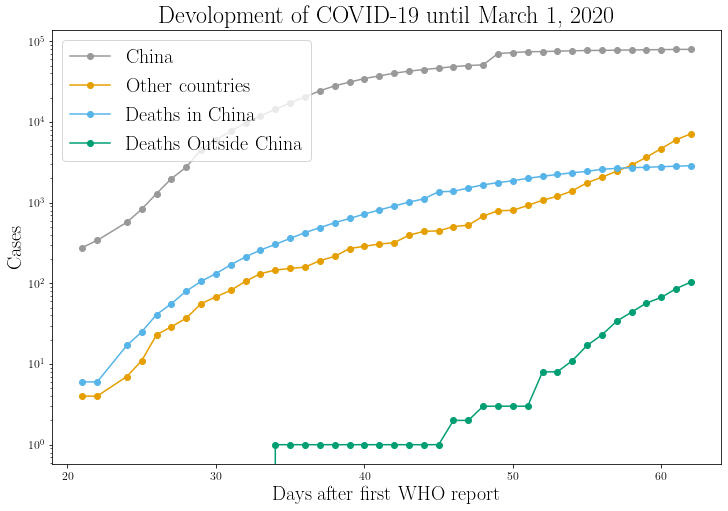

In [4]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

### Defining the model

We use a SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

### Initial Conditions

In [ ]:
Hubei = 5917*10**4
Guangdong = 11346*10**4
Henan = 9605*10**4
Zhejiang = 5737*10**4
Hunan = 6899*10**4
Anhui = 6324*10**4
Jiangxi = 4648*10**4
N = 56*10**3                        # estimate of people affected by lock down
init_I = 1
init_R = 1

# Mi parte programa y en Jupyter Notebook.

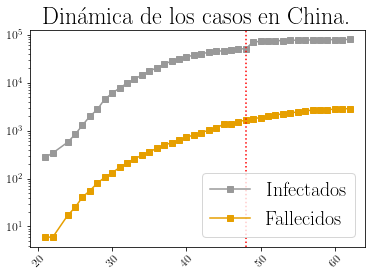

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PDEparams as pde

data = pd.read_csv('CoV2019.csv')
china = data["China"][:]  # data["China"][:27]
days = data["Days"][:]
total = data["Total"][:]
deaths_china = data["Death China"][:]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]
# Vamos a suponer que si estás en R si estás muerto.

N = 56 * 10 ** 3  # estimate of people affected by lock down

#-----------------------------------------------------------------
#Generamos el gráfico para ver la base en los primeros meses

exact_date = days
I = china.copy()
R = deaths_china_total.copy()

fig, ax = plt.subplots()
ax.set_title("Dinámica de los casos en China.")
ax.plot(exact_date, I, label = 'Infectados', marker ='s')
ax.plot(exact_date, R, label = 'Fallecidos', marker ='s')
ax.set_yscale("log")
ax.legend()
I = china.copy() / N
h_lim = exact_date[I[I > 1].index[0]]
ax.axvline(h_lim-1, color = 'red', linestyle =':')
ax.xaxis.set_tick_params(rotation=45)
fig.savefig("images/dinamica.pdf")
fig.show()

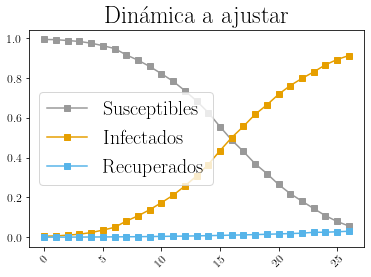

In [33]:
#Ya con la tranformación
I = china.copy() / N
R = deaths_china_total.copy() / N
bool_array = (I <= 1)
I = I[bool_array]
R = R[bool_array]
S = 1 - I - R
fig, ax = plt.subplots()
ax.set_title("Dinámica a ajustar")
ax.plot(exact_date[bool_array].index, 1 - R - I, label = 'Susceptibles', marker ='s')
ax.plot(exact_date[bool_array].index, I, label = 'Infectados', marker ='s')
ax.plot(exact_date[bool_array].index, R, label = 'Recuperados', marker ='s')
#ax.set_yscale("log")
ax.legend()
#ax.axvline(h_lim-1, color = 'red', linestyle =':')
ax.xaxis.set_tick_params(rotation=45)
fig.savefig("images/buenosdatos.pdf")
fig.show()

In [3]:
I = china.copy() / N
R = deaths_china_total.copy() / N
bool_array = (I <= 1)
I = I[bool_array]
R = R[bool_array]
S = 1 - I - R

init_I = I[0]
init_R = R[0]
init_S = S[0]

# fig, ax = plt.subplots()
# ax.plot(days[bool_array].index, S, color ='blue', marker = 's', alpha= 0.5,
#        label = 'Datos S')
# ax.plot(days[bool_array].index, I, color ='green',marker = 's',alpha= 0.5,
#        label = 'Datos I')
# ax.plot(days[bool_array].index, R, color ='red',marker = 's',alpha= 0.5,
#        label = 'Datos R')
# plt.show()



# -----------------------------------------------------------
# ------------- Primer ajuste -------------------------------
# -----------------------------------------------------------
def covid(z, t, a, b):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no
    pre-processing is needed.

    t is the current time.

    a and b correspond to the unknown parameters.
    '''

    x, y = z

    return [-b * x * y,
            b * x * y - a*y]


def initial_x():
    return init_S

def initial_y():
    return init_I



new_df = pd.DataFrame({'0': days[bool_array].index,
                       '1': S,
                       '2': I})


my_model = pde.PDEmodel(new_df, covid, [initial_x, initial_y], bounds=[(0.001, 0.02), (0.2,0.5)],
                         param_names=[r'$\gamma$', r'$\beta$'], nvars=2, ndims=0, nreplicates=1)

In [4]:
#Lo ajustamos
my_model.fit()

   $\gamma$   $\beta$
0   0.00924  0.340121


In [5]:
#Mejores parámetros
print(my_model.best_params)

   $\gamma$   $\beta$
0   0.00924  0.340121


In [8]:
#Error
print(my_model.best_error)

0.0010679596835475133


In [9]:
data_profiles = my_model.likelihood_profiles()
#my_model.plot_profiles()
#plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


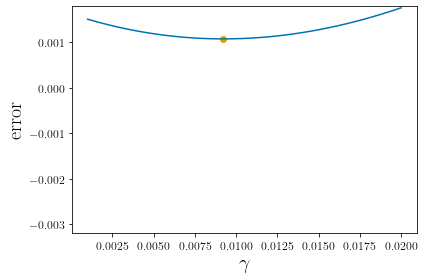

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


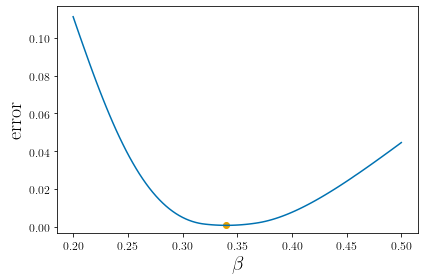

In [14]:
my_model.plot_profiles()

In [16]:
%%time
my_model.bootstrap()


         $\gamma$     $\beta$
count  100.000000  100.000000
mean     0.009240    0.340122
std      0.000005    0.000012
min      0.009210    0.340054
25%      0.009240    0.340121
50%      0.009240    0.340121
75%      0.009240    0.340121
max      0.009267    0.340183
Wall time: 39.1 s


In [17]:
my_model.bootstrap_summary

,$\gamma$,$\beta$
count,100.000000,100.000000
mean,0.009240,0.340122
std,0.000005,0.000012
min,0.009210,0.340054
25%,0.009240,0.340121
50%,0.009240,0.340121
75%,0.009240,0.340121
max,0.009267,0.340183


Text(0, 0.5, '$\\gamma$')

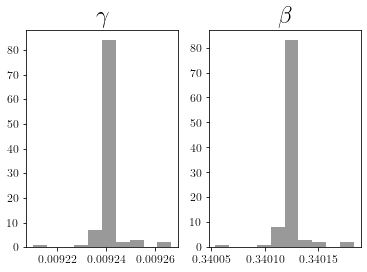

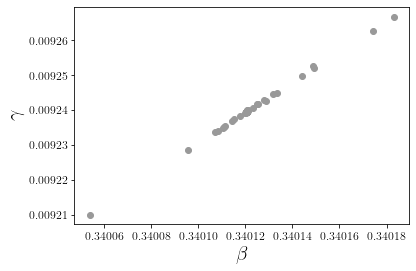

In [30]:
gamma = my_model.bootstrap_raw.iloc[:,0]
beta = my_model.bootstrap_raw.iloc[:,1]

fig, ax = plt.subplots(1,2)
ax[0].hist(gamma)
ax[1].hist(beta)

ax[0].set_title(r"$\gamma$")
ax[1].set_title(r"$\beta$")

fig, ax = plt.subplots()
ax.scatter(beta,gamma)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")

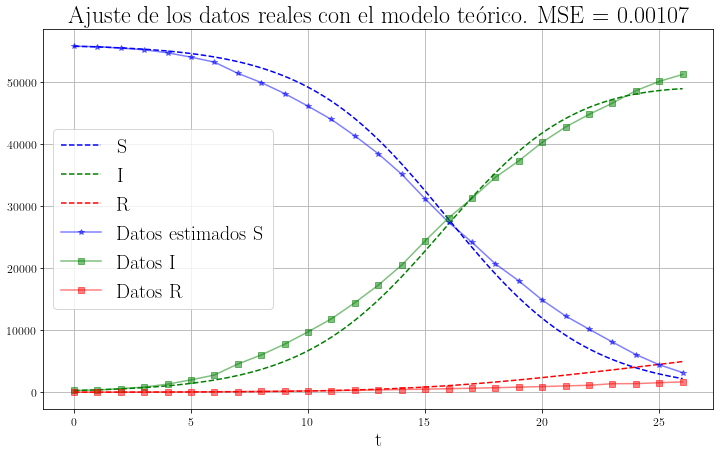

In [45]:
from scipy.integrate import odeint
def pend(x, t, beta, gamma):
    s, i, r = x
    dxdt = [-beta*s*i, 
            beta*s*i - gamma*i , 
            gamma*i]
    return dxdt

y0 = [0.9949285714285714,
      0.0049642857142857145,
      0.00010714285714285714]
t = np.linspace(0, 26, 100)

beta = 0.340121
#beta = 0.34
gamma = 0.00924
#gamma = 0.000924
sol = odeint(pend, y0, t, args=(beta, gamma))
N = 56 * 10 ** 3

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches([12,7])
ax.plot(t, N*sol[:, 0], 'blue', label='S', linestyle = '--')
ax.plot(t, N*sol[:, 1], 'green', label='I', linestyle = '--')
ax.plot(t, N*sol[:, 2], 'red', label='R', linestyle = '--')
I = china.copy() 
R = deaths_china_total.copy() 
ax.plot(days[bool_array].index, N*S, color ='blue', marker = '*', alpha= 0.5,
       label = 'Datos estimados S')
ax.plot(days[bool_array].index, I[bool_array], color ='green',marker = 's',alpha= 0.5,
       label = 'Datos I')
ax.plot(days[bool_array].index, R[bool_array], color ='red',marker = 's',alpha= 0.5,
       label = 'Datos R')
ax.legend(loc='best')
ax.set_xlabel('t')
#ax.set_yscale('log')
ax.set_title("Ajuste de los datos reales con el modelo teórico. MSE = {:.5f}".format(0.0010679596835475133))
ax.grid()

fig.savefig("images/ajustefinal.pdf")